<a href="https://colab.research.google.com/github/naoya1110/road_following_by_regression/blob/main/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Road Following by Regression - Train Model

## Introduction
Once you have finished data collection for you road following task, you need to train a model with your dataset.

### GPU
Please make sure we can use GPU for training a model.

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### General Python Packages
Let's import general Python packages.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm.notebook import tqdm
import shutil
import glob
import PIL.Image

## Data Preparation

### Upload & Extract Dataset

We need to upload the `dataset_reg.zip` file in the file browser of the Google Colab. Uploading the zip file takes for a while depending the size of your dataset. After uploading is finished, you can extract it with the next command.

In [3]:
! unzip -q dataset_reg.zip

Now we can find a directory named ``dataset_reg`` in the file browser.

#### *If your `dataset_reg.zip` file is in your google drive*

First you need to mount your google drive with the next command.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then extract the `dataset_reg.zip` file. Remenber to change the file path appropriate for your `dataset_reg.zip`.

In [ ]:
!unzip -q /path/to/your/dataset_reg.zip

### Remove Broken Data
The dataset directory may contain some broken image data or unnecessary directories for some reasons. Such data will cause errors when we train the model. So it is better to remove such data before training.

In [4]:
dataset_dir = "dataset_reg"
filenames = sorted(os.listdir(dataset_dir))

for filename in filenames:
    path = os.path.join(dataset_dir, filename)
    img = cv2.imread(path)
    if img is None:
        try:
            os.remove(path)
            print("Removed", path)
        except IsADirectoryError:
            shutil.rmtree(path)
            print("Removed", path)

### Create Dataset
Now we use the ``ImageFolder`` dataset class available with the ``torchvision.datasets`` package.  We attach transforms from the ``torchvision.transforms`` package to prepare the data for training.  

In [5]:
import torch
import torchvision.transforms as transforms

def get_x(path, width):
    """Gets the x value from the image filename"""
    return float(int(path.split("_")[3])) / width

def get_y(path, height):
    """Gets the y value from the image filename"""
    return float(int(path.split("_")[4])) / height

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

class RegDataset(torch.utils.data.Dataset):
    
    def __init__(self, directory):
        self.directory = directory
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.1, 0.1, 0.1, 0.1)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        image = PIL.Image.open(image_path)
        width, height = image.size
        x = float(get_x(os.path.basename(image_path), width))
        y = float(get_y(os.path.basename(image_path), height))

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, means, stds)
        
        return image, torch.tensor([x, y]).float()
    
dataset = RegDataset('dataset_reg')
print("Number of data:", len(dataset))

Number of data: 2125


### Data Distribution
Let's visualize the distribution of x and y data.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


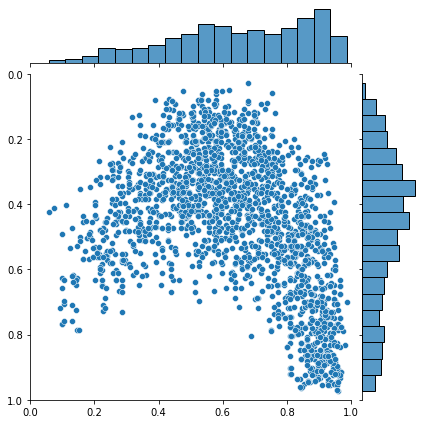

In [8]:
x_list = []
y_list = []
for i in range(len(dataset)):
    _, xy = dataset[i]
    x_list.append(xy[0])
    y_list.append(xy[1])

sns.jointplot(np.array(x_list), np.array(y_list), xlim=(0, 1), ylim=(1, 0))

### Train Test Split
We need to split the dataset into training and testing datasets.

In [9]:
test_size = 200
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size])

### Data Loaders
Then we can make data loaders for the training and testing datasets.

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=50,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=50,
    shuffle=False,
    num_workers=2
)

## Model Building

### Model Architecture
We build a relatively simple CNN model but you can use any models you want.

In [19]:
import torch.nn as nn

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(64*7*7, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),    # dropout layer
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias

### torchinfo

In [20]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

torch.Size([50, 3, 224, 224])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [50, 64, 7, 7]            --
│    └─Conv2d: 2-1                       [50, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [50, 64, 224, 224]        --
│    └─MaxPool2d: 2-3                    [50, 64, 112, 112]        --
│    └─Conv2d: 2-4                       [50, 64, 112, 112]        36,928
│    └─ReLU: 2-5                         [50, 64, 112, 112]        --
│    └─MaxPool2d: 2-6                    [50, 64, 56, 56]          --
│    └─Conv2d: 2-7                       [50, 64, 56, 56]          36,928
│    └─ReLU: 2-8                         [50, 64, 56, 56]          --
│    └─MaxPool2d: 2-9                    [50, 64, 28, 28]          --
│    └─Conv2d: 2-10                      [50, 64, 28, 28]          36,928
│    └─ReLU: 2-11                        [50, 64, 28, 28]          --


## Training

### Training Loop

Now we can train the model. Since this is a regresion model we are going to use `MSELoss()` as the loss function.

In [21]:
import torch.optim as optim

model = Model()
model = model.to(device)

loss_func = nn.MSELoss()                      # use MSE loss function.
optimizer = optim.Adam(model.parameters(), lr=1E-4)    # set optimizer
epochs = 30

best_model_path = 'best_model_reg.pth'
best_loss = 1E+9

# create empty lists for saving metrics during training
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    print("-----------------------------")
    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics
    train_loss = 0
    test_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value

        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(test_loader)
        pbar.set_description("Test") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            test_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label

            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    #------------------------#

    train_loss = train_loss/len(train_loader)                 # determine loss for training data
    test_loss = test_loss/len(test_loader)                    # determine loss for test data 

    # show and store metrics
    print(f"Train Loss={train_loss:.5f}, Test Loss={test_loss:.5f}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    # save the model if test accuracy is better than before
    if test_loss < best_loss:
        torch.save(model.state_dict(), best_model_path)
        print(f"Test loss decreased from {best_loss:.3f} to {test_loss:.3f}")
        print(f"Model saved at {best_model_path}")
        best_loss = test_loss

-----------------------------
Epoch 1/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.12707, Test Loss=0.05369
Test loss decreased from 1000000000.000 to 0.054
Model saved at best_model_reg.pth
-----------------------------
Epoch 2/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.06058, Test Loss=0.04675
Test loss decreased from 0.054 to 0.047
Model saved at best_model_reg.pth
-----------------------------
Epoch 3/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.05428, Test Loss=0.04086
Test loss decreased from 0.047 to 0.041
Model saved at best_model_reg.pth
-----------------------------
Epoch 4/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.04538, Test Loss=0.03464
Test loss decreased from 0.041 to 0.035
Model saved at best_model_reg.pth
-----------------------------
Epoch 5/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.03822, Test Loss=0.02967
Test loss decreased from 0.035 to 0.030
Model saved at best_model_reg.pth
-----------------------------
Epoch 6/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.03353, Test Loss=0.02623
Test loss decreased from 0.030 to 0.026
Model saved at best_model_reg.pth
-----------------------------
Epoch 7/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.03116, Test Loss=0.02284
Test loss decreased from 0.026 to 0.023
Model saved at best_model_reg.pth
-----------------------------
Epoch 8/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.03224, Test Loss=0.02612
-----------------------------
Epoch 9/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02992, Test Loss=0.02306
-----------------------------
Epoch 10/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02813, Test Loss=0.01899
Test loss decreased from 0.023 to 0.019
Model saved at best_model_reg.pth
-----------------------------
Epoch 11/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02603, Test Loss=0.01992
-----------------------------
Epoch 12/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02571, Test Loss=0.01989
-----------------------------
Epoch 13/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02641, Test Loss=0.01780
Test loss decreased from 0.019 to 0.018
Model saved at best_model_reg.pth
-----------------------------
Epoch 14/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02438, Test Loss=0.01853
-----------------------------
Epoch 15/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02365, Test Loss=0.01725
Test loss decreased from 0.018 to 0.017
Model saved at best_model_reg.pth
-----------------------------
Epoch 16/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02292, Test Loss=0.01808
-----------------------------
Epoch 17/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02276, Test Loss=0.01568
Test loss decreased from 0.017 to 0.016
Model saved at best_model_reg.pth
-----------------------------
Epoch 18/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02166, Test Loss=0.01580
-----------------------------
Epoch 19/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02157, Test Loss=0.01416
Test loss decreased from 0.016 to 0.014
Model saved at best_model_reg.pth
-----------------------------
Epoch 20/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02003, Test Loss=0.01559
-----------------------------
Epoch 21/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02042, Test Loss=0.01608
-----------------------------
Epoch 22/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02102, Test Loss=0.01448
-----------------------------
Epoch 23/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01967, Test Loss=0.01376
Test loss decreased from 0.014 to 0.014
Model saved at best_model_reg.pth
-----------------------------
Epoch 24/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.02002, Test Loss=0.01572
-----------------------------
Epoch 25/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01922, Test Loss=0.01622
-----------------------------
Epoch 26/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01944, Test Loss=0.01492
-----------------------------
Epoch 27/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01845, Test Loss=0.01331
Test loss decreased from 0.014 to 0.013
Model saved at best_model_reg.pth
-----------------------------
Epoch 28/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01815, Test Loss=0.01333
-----------------------------
Epoch 29/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01836, Test Loss=0.01346
-----------------------------
Epoch 30/30


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss=0.01788, Test Loss=0.01336


### Learning Curves
Let's check the learning curves.

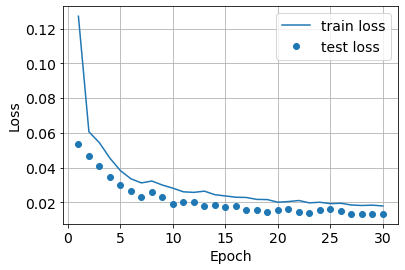

In [22]:
plt.rcParams["font.size"]=14
real_epochs = np.arange(len(train_loss_list))+1

plt.plot(real_epochs, train_loss_list, c="#1f77b4", label="train loss")
plt.plot(real_epochs, test_loss_list, lw=0, marker="o", c="#1f77b4", label="test loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

### Load The Best Model
Let's load the best model parameters.

In [23]:
model.load_state_dict(torch.load(best_model_path))   # load model parameters to the initialized model

<All keys matched successfully>

Text(0.5, 1.0, 'y position')

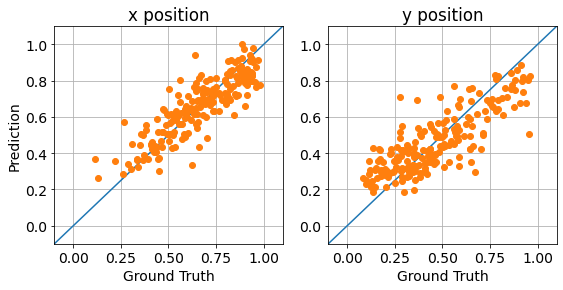

In [24]:
truths = []
preds = []

with torch.no_grad():   # disable autograd for saving memory usage
    model.eval()        # set model to evaluation mode

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        p_batch = model(x_batch)    # predict

        p_batch = p_batch.to("cpu").numpy()
        y_batch = y_batch.to("cpu").numpy()
        preds.append(p_batch)
        truths.append(y_batch)

preds = np.array(preds).reshape(test_size, 2)
truths = np.array(truths).reshape(test_size, 2)

plt.figure(figsize=(9, 4))

plt.subplot(1, 2, 1)
plt.plot([-1.2, 1.2], [-1.2, 1.2])
plt.plot(truths[:,0], preds[:,0], lw=0, marker="o")
plt.grid()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("Ground Truth")
plt.ylabel("Prediction")
plt.title("x position")

plt.subplot(1, 2, 2)
plt.plot([-1.2, 1.2], [-1.2, 1.2])
plt.plot(truths[:,1], preds[:,1], lw=0, marker="o")
plt.grid()
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("Ground Truth")
plt.title("y position")

### Predictions for Test Data
Let's see the predictions for the test dataset.

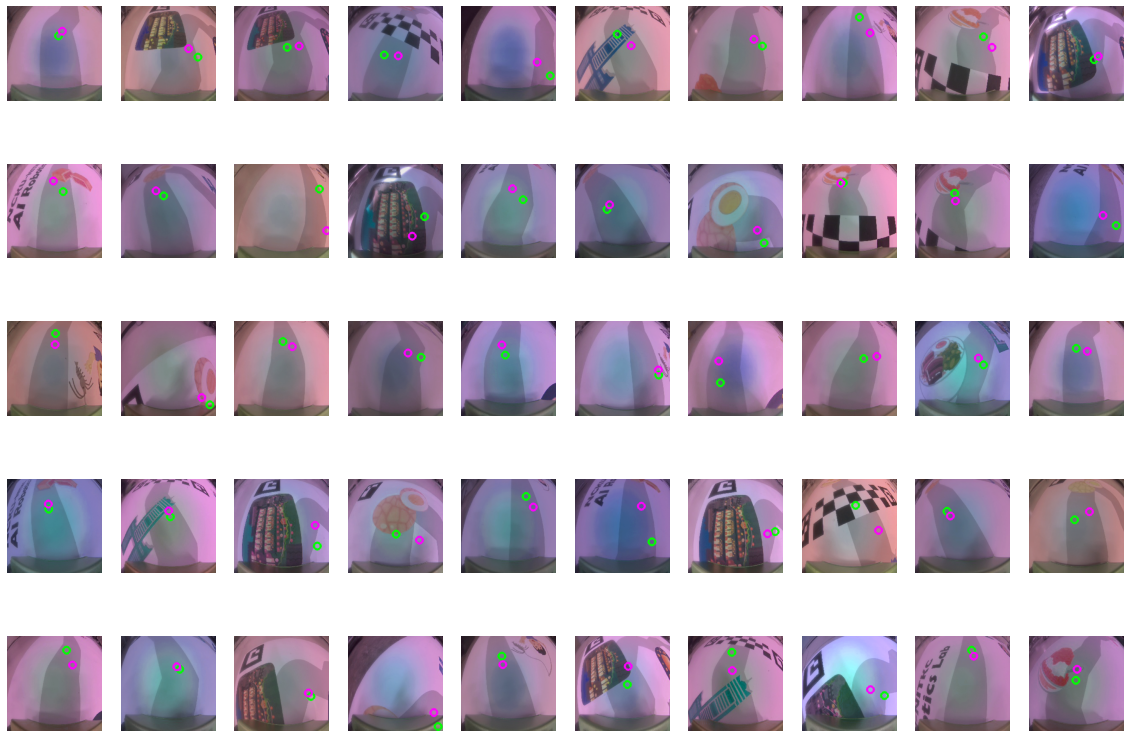

In [25]:
plt.figure(figsize=(20, 14))

GREEN = (0, 255, 0)

for i in range(50):
    image, xy = test_dataset[i]
    image = np.transpose(image, (1,2,0))
    
    image[:, :, 0] = image[:, :, 0]*stds[0]+means[0]
    image[:, :, 1] = image[:, :, 1]*stds[1]+means[1]
    image[:, :, 2] = image[:, :, 2]*stds[2]+means[2]

    x = int(xy[0].item()*224)
    y = int(xy[1].item()*224)

    image = (255*image).numpy().astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(5, 10, i+1)

    xy_truth = tuple((truths[i]*224).astype("int"))
    xy_pred = tuple((preds[i]*224).astype("int"))

    image = cv2.circle(image, xy_truth, 8, (0, 255, 0), 3)
    image = cv2.circle(image, xy_pred, 8, (255, 0, 255), 3)
    plt.imshow(image)

    plt.axis("off")

## Download Model
Once you finished training, download `best_model_reg.pth` from the file browser and upload it to your JetBot.